In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle

analysis_name = 'simulated_data_small'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [3]:
class LogisticGLMMLogPosterior(object):
    def __init__(
        self, glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec):

        self.glmm_par_draw = copy.deepcopy(glmm_par_draw)
        self.prior_par = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.K = x_mat.shape[1]

        assert np.min(y_g_vec) == 0
        assert np.max(y_g_vec) == self.glmm_par_draw['u'].size() - 1

    def get_log_prior(self):
        beta = self.glmm_par_draw['beta'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)
        
        cov_beta = np.zeros((self.K, self.K))
        beta_prior_info = self.prior_par['beta_prior_info'].get()
        beta_prior_mean = self.prior_par['beta_prior_mean'].get()
        log_p_beta = ef.mvn_prior(
            beta_prior_mean, beta_prior_info, beta, cov_beta)

        log_p_mu = ef.uvn_prior(
            self.prior_par['mu_prior_mean'].get(),
            self.prior_par['mu_prior_info'].get(), mu, 0.0)

        tau_prior_shape = self.prior_par['tau_prior_alpha'].get()
        tau_prior_rate = self.prior_par['tau_prior_beta'].get()
        log_p_tau = ef.gamma_prior(
            tau_prior_shape, tau_prior_rate, tau, log_tau)

        return log_p_beta + log_p_mu + log_p_tau

    def get_log_lik(self):
        beta = self.glmm_par_draw['beta'].get()
        u = self.glmm_par_draw['u'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)

        log_lik = 0.

        # Log likelihood from data.
        z = u[self.y_g_vec] + np.matmul(self.x_mat, beta)
        log_lik += np.sum(self.y_vec * z - np.log1p(np.exp(z)))

        # Log likelihood from random effect terms.
        log_lik += -0.5 * tau * np.sum((mu - u) ** 2) + 0.5 * log_tau * len(u)

        return log_lik

    def get_log_posterior(self):
        return np.squeeze(
            self.get_log_lik() + \
            self.get_log_prior())




In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])


glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))

log_model = LogisticGLMMLogPosterior(glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec)
log_model.get_log_posterior()

-696.14718055994535

In [5]:
class LogisticGLMMBootstrap(object):
    def __init__(self, model):
        self.model = model
        self.weights = np.full(model.x_mat.shape[0], 1.0)
        
    def wrap_data_log_lik_terms(self, free_par):
        self.model.glmm_par.set_free(free_par)
        return self.model.get_data_log_lik_terms()
    
glmm_bootstrap_object = LogisticGLMMBootstrap(model)

get_weight_jacobian = autograd.jacobian(glmm_bootstrap_object.wrap_data_log_lik_terms)


In [6]:
glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_data['elbo_hess']

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)


(108, 224)
(224, 224)
(1000, 224)


In [104]:

objective = Objective(model.glmm_par, model.get_kl)
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, weights, num_gh_points=4, gtol=1e-6, maxiter=500):
    model.use_weights = True
    model.set_gh_points(num_gh_points)
    model.weights = copy.deepcopy(weights)
    objective.logger.initialize()
    objective.logger.print_every = 1
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x

def get_model_weight_grad(free_par_vec, weights, num_gh_points=4):
    model.use_weights = True
    model.set_gh_points(num_gh_points)
    model.weights = copy.deepcopy(weights)
    return objective.fun_free_grad(free_par_vec)


In [107]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
glmm_par_opt = tr_optimize(glmm_par_free, base_weights)


1000.0
Iter  0  value:  69.3309807058
	x_diff:  inf
Iter  1  value:  69.3309807058
	x_diff:  4.35241612085e-07
Optimization terminated successfully.
         Current function value: 69.330981
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0


In [108]:
kl_hess = objective.fun_free_hessian(glmm_par_opt)
moment_jac = get_moment_jacobian(glmm_par_opt)
weight_jacobian = get_weight_jacobian(glmm_par_opt)
param_boot_mat = -1 * np.linalg.solve(elbo_hess, np.transpose(weight_jacobian))
moment_boot_mat = np.matmul(moment_jac, param_boot_mat)
print(moment_boot_mat.shape)

(108, 1000)


In [142]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.
boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
boot_draw = 1.0 * boot_draw + base_weights
print(np.sum(boot_draw))

lr_param_diff = np.matmul(param_boot_mat, np.squeeze(boot_draw) - 1.0)
model_weight_grad = get_model_weight_grad(glmm_par_opt + lr_param_diff, boot_draw)
boot_newton_step = -1 * np.linalg.solve(elbo_hess, model_weight_grad)
print(np.max(np.abs(boot_newton_step)))

1000.0
2.56836578438


In [143]:
glmm_par_opt_boot = tr_optimize(glmm_par_opt + lr_param_diff, boot_draw)

Iter  0  value:  48.734837337
	x_diff:  inf
Iter  1  value:  47.9475161881
	x_diff:  0.0766278200838
Iter  2  value:  46.8649242236
	x_diff:  0.434501478695
Iter  3  value:  46.137853689
	x_diff:  0.412488883121
Iter  4  value:  44.7749494842
	x_diff:  0.670437652872
Iter  5  value:  44.4107318823
	x_diff:  0.306124273883
Iter  6  value:  43.1680610615
	x_diff:  1.41923732888
Iter  7  value:  43.1420620205
	x_diff:  0.0158969397416
Iter  8  value:  42.9258576793
	x_diff:  0.244961346955
Iter  9  value:  42.7837361039
	x_diff:  0.336277087753
Iter  10  value:  42.7064397707
	x_diff:  0.483761405039
Iter  11  value:  42.7061938099
	x_diff:  0.00157138827503
Iter  12  value:  42.7044794872
	x_diff:  0.029946450906
Iter  13  value:  42.7043720391
	x_diff:  0.0113863033182
Iter  14  value:  42.7043713579
	x_diff:  0.00187733451212
Iter  15  value:  42.7043713577
	x_diff:  3.85985490085e-05
Optimization terminated successfully.
         Current function value: 42.704371
         Iterations: 

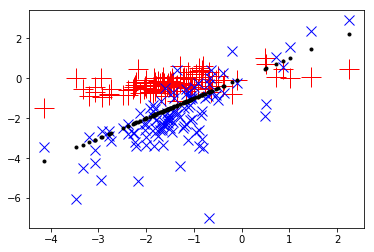

In [144]:
moment_vec = moment_wrapper.get_moment_vector(glmm_par_opt)
moment_vec_boot = moment_wrapper.get_moment_vector(glmm_par_opt_boot)
moment_vec_boot_step = moment_wrapper.get_moment_vector(
    glmm_par_opt + lr_param_diff + boot_newton_step)
#moment_vec_boot_step = moment_wrapper.get_moment_vector(glmm_par_opt - param_diff)

true_moment_diff = moment_vec_boot - moment_vec
boot_step_moment_diff = moment_vec_boot - moment_vec_boot_step
lr_moment_diff = np.matmul(moment_boot_mat, np.squeeze(boot_draw) - 1.0)

#plt.plot(moment_vec, moment_vec_boot, 'k.')
plt.plot(true_moment_diff, lr_moment_diff, 'r+', markersize=20)
plt.plot(true_moment_diff, boot_step_moment_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')

Moment Parameters:
	e_beta:
[0 1 2 3 4]
	e_mu: [5]
	e_tau: [6]
	e_log_tau: [7]
	e_u:
[  8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107]
[0, 1, 2, 3, 4, 5, 6, 7]


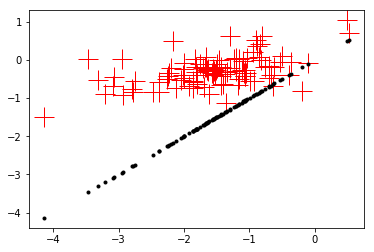

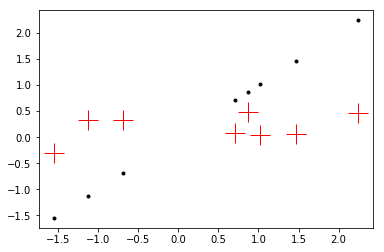

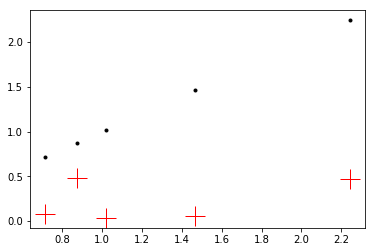

In [145]:
moment_indices = copy.deepcopy(moment_wrapper.moment_par)
moment_indices.set_vector(np.arange(0, moment_indices.vector_size()))
print(moment_indices)
u_ind = moment_indices['e_u'].get()
beta_ind = moment_indices['e_beta'].get()
non_u_ind = list(set(moment_indices.get_vector()) - set(u_ind))
print(non_u_ind)

#true_moment_diff[u_ind]

plt.figure()
plt.plot(true_moment_diff[u_ind], lr_moment_diff[u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[u_ind], true_moment_diff[u_ind], 'k.')

plt.figure()
plt.plot(true_moment_diff[non_u_ind], lr_moment_diff[non_u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[non_u_ind], true_moment_diff[non_u_ind], 'k.')


plt.figure()
plt.plot(true_moment_diff[beta_ind], lr_moment_diff[beta_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[beta_ind], true_moment_diff[beta_ind], 'k.')